<a href="https://colab.research.google.com/github/ganji759/PINNs-for-Thermoacoustic/blob/main/PINN_for_pressure_and_velocity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adam Epoch [1000/10000], Loss: 0.303411
Adam Epoch [2000/10000], Loss: 1.440507
Adam Epoch [3000/10000], Loss: 0.224197
Adam Epoch [4000/10000], Loss: 0.101882
Adam Epoch [5000/10000], Loss: 0.097710
Adam Epoch [6000/10000], Loss: 0.107297
Adam Epoch [7000/10000], Loss: 0.050728
Adam Epoch [8000/10000], Loss: 0.771730
Adam Epoch [9000/10000], Loss: 0.044682
Adam Epoch [10000/10000], Loss: 0.052208
L-BFGS Epoch [1/2000], Loss: 0.041039
L-BFGS Epoch [500/2000], Loss: 0.000126
L-BFGS Epoch [1000/2000], Loss: 0.000125
L-BFGS Epoch [1500/2000], Loss: 0.000129
L-BFGS Epoch [2000/2000], Loss: 0.000130


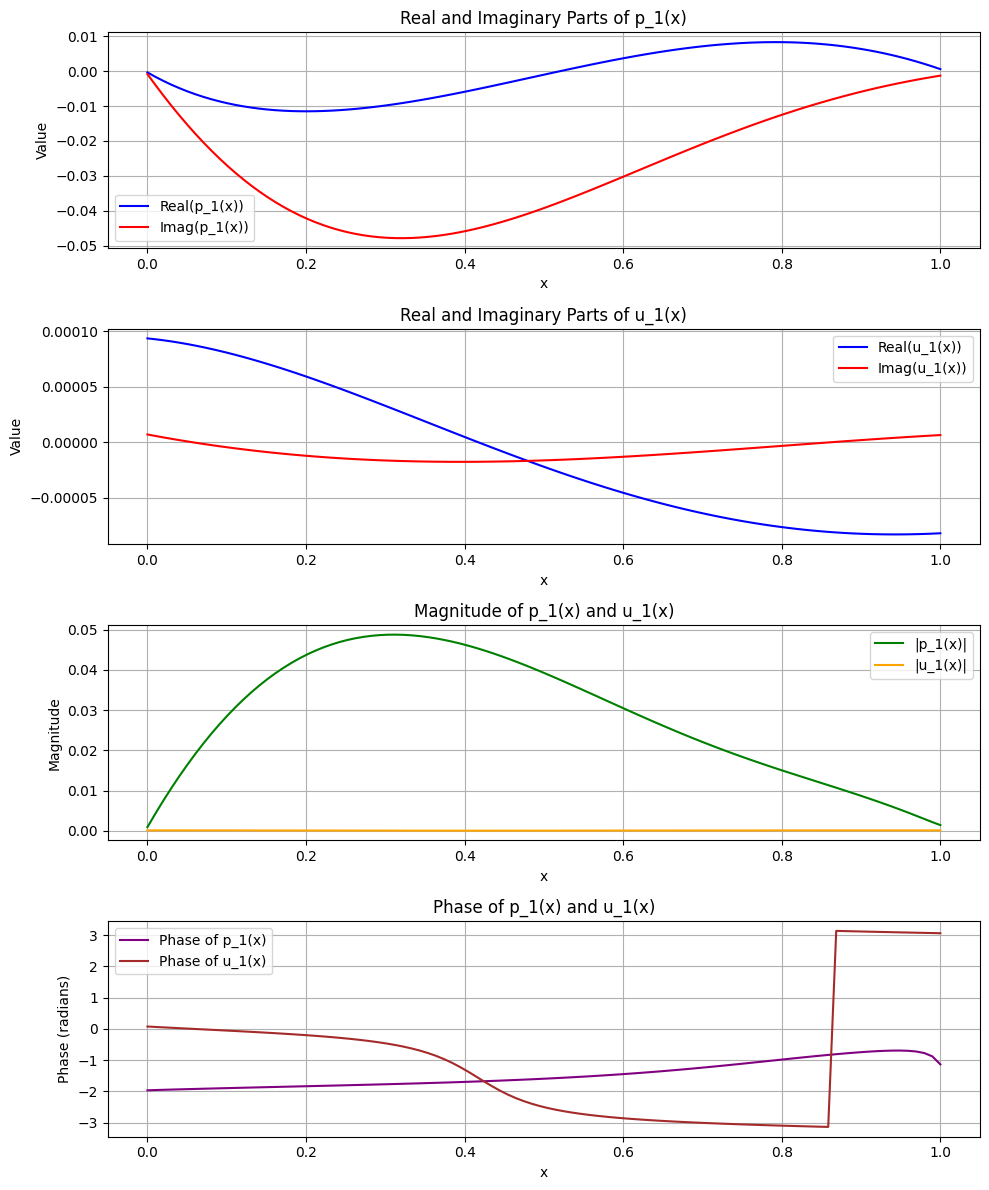

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Function to define gas (air) properties
def get_gas_properties():
    gas_props = {
        'gamma': 1.4,
        'p_m': 101325,
        'T_0': 293,
        'R': 8.314,
        'M': 0.029,
        'kappa': 0.026,
        'cp': 1005,
        'mu': 1.81e-5,
        'omega': 2 * np.pi * 100,
        'sigma': 0.71
    }
    gas_props['rho_m'] = gas_props['p_m'] * gas_props['M'] / (gas_props['R'] * gas_props['T_0'])
    gas_props['a'] = np.sqrt(gas_props['gamma'] * gas_props['R'] * gas_props['T_0'] / gas_props['M'])
    gas_props['beta'] = 1 / gas_props['T_0']
    gas_props['delta_k'] = np.sqrt(gas_props['kappa'] / (gas_props['rho_m'] * gas_props['cp'] * gas_props['omega']))
    gas_props['delta_v'] = np.sqrt(gas_props['mu'] / (gas_props['rho_m'] * gas_props['omega']))
    return gas_props

# Function to define stack properties
def get_stack_properties():
    stack_props = {
        'kappa_s': 0.1,
        'rho_s': 2500,
        'c_ps': 900,
        'l_s': 0.01,
        'r_s': 0.001,
        'r_v': 0.001,
        'r_k': 0.001
    }
    return stack_props

# Define the neural network for complex-valued output (p_1 and U_1)
class CoupledPINN(nn.Module):
    def __init__(self, num_hidden=32):
        super(CoupledPINN, self).__init__()
        self.net_p1 = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, 2)
        )
        self.net_u1 = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, 2)
        )
        self.scale_p1 = torch.tensor(100.0)  # Adjusted scale for p_1 (pressure in Pa)
        self.scale_u1 = torch.tensor(0.01)   # Adjusted scale for U_1 (velocity in m/s)

    def forward(self, x):
        p1_out = self.net_p1(x)
        u1_out = self.net_u1(x)
        p_1 = (p1_out[:, 0:1] + 1j * p1_out[:, 1:2]) * self.scale_p1
        u_1 = (u1_out[:, 0:1] + 1j * u1_out[:, 1:2]) * self.scale_u1
        return p_1, u_1

# Get properties
gas_props = get_gas_properties()
stack_props = get_stack_properties()

# Compute derived stack properties
delta_s = np.sqrt(stack_props['kappa_s'] / (stack_props['rho_s'] * stack_props['c_ps'] * gas_props['omega']))
epsilon_s = np.sqrt(stack_props['kappa_s'] * stack_props['rho_s'] * stack_props['c_ps']) * np.tanh((1 + 1j) * stack_props['l_s'] / delta_s / stack_props['r_s'])
epsilon_s = torch.tensor(epsilon_s, dtype=torch.complex64)

# Complex functions f_v and f_k
f_v = torch.tensor(np.tanh((1 + 1j) * stack_props['l_s'] / gas_props['delta_v'] / stack_props['r_v']), dtype=torch.complex64)
f_k = torch.tensor(np.tanh((1 + 1j) * stack_props['l_s'] / gas_props['delta_k'] / stack_props['r_k']), dtype=torch.complex64)

# Regularization for denominators
epsilon = 1e-3  # Increased epsilon

# Mean temperature gradient
grad_T = 50  # K/m
def T_m(x):
    return gas_props['T_0'] + grad_T * x

# Area (assumed constant)
A = 1.0  # m^2

# Physics-informed loss function
def compute_loss(model, x, L=1.0):
    x = x.requires_grad_(True)

    p_1, u_1 = model(x)

    # Compute derivatives
    p_1_x = torch.autograd.grad(p_1, x, grad_outputs=torch.ones_like(p_1), create_graph=True)[0]
    u_1_x = torch.autograd.grad(u_1, x, grad_outputs=torch.ones_like(u_1), create_graph=True)[0]

    # Mean temperature derivative
    dTm_dx = torch.ones_like(x) * grad_T
    T_m_x = T_m(x)

    # Normalize coefficients
    coeff1 = gas_props['omega'] * gas_props['rho_m'] / (1 - f_v + epsilon) / A
    coeff2 = gas_props['omega'] * A / (gas_props['gamma'] * gas_props['p_m'])
    coeff3 = (f_k - f_v) / ((1 - f_v + epsilon) * (1 - gas_props['sigma'] + epsilon))

    # PDE residuals (normalized)
    pde1_residual = p_1_x / coeff1 + 1j * u_1
    pde2_residual = u_1_x / coeff2 + 1j * (1 + (gas_props['gamma'] - 1) * f_k) * p_1 + \
                    (coeff3 / coeff2) * (dTm_dx / T_m_x) * u_1

    # Weighted losses
    pde1_loss = torch.mean(pde1_residual.abs()**2)
    pde2_loss = torch.mean(pde2_residual.abs()**2)
    total_pde_loss = 1.0 * pde1_loss + 1.0 * pde2_loss

    # Boundary conditions: p_1(0) = p_1(L) = 0, u_1(0) = u_1(L) = 0
    x_bc = torch.tensor([[0.0], [L]], requires_grad=True)
    p_1_bc, u_1_bc = model(x_bc)
    bc_loss_p1 = torch.mean(p_1_bc.abs()**2)
    bc_loss_u1 = torch.mean(u_1_bc.abs()**2)
    total_bc_loss = 1.0 * bc_loss_p1 + 1.0 * bc_loss_u1

    return total_pde_loss + total_bc_loss

# Training function with Adam followed by L-BFGS
def train(model, num_epochs_adam=10000, num_epochs_lbfgs=2000, num_points=1000):
    # Adam optimization with gradient clipping
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs_adam):
        x = torch.rand(num_points, 1)
        optimizer.zero_grad()
        loss = compute_loss(model, x)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Stopping Adam at epoch {epoch+1}: Loss became nan or inf")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if (epoch + 1) % 1000 == 0:
            print(f'Adam Epoch [{epoch+1}/{num_epochs_adam}], Loss: {loss.item():.6f}')

    # L-BFGS optimization with gradient clipping
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, max_eval=25, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=100)
    def closure():
        optimizer.zero_grad()
        x = torch.rand(num_points, 1)
        loss = compute_loss(model, x)
        if torch.isnan(loss) or torch.isinf(loss):
            print("L-BFGS: Loss became nan or inf")
            return loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        return loss
    for epoch in range(num_epochs_lbfgs):
        loss = optimizer.step(closure)
        if (epoch + 1) % 500 == 0 or epoch == 0:
            print(f'L-BFGS Epoch [{epoch+1}/{num_epochs_lbfgs}], Loss: {loss.item():.6f}')

# Plotting function
def plot_solution(model):
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    with torch.no_grad():
        p_1, u_1 = model(x)
        p_1_real = p_1.real.numpy()
        p_1_imag = p_1.imag.numpy()
        u_1_real = u_1.real.numpy()
        u_1_imag = u_1.imag.numpy()
        p_1_mag = p_1.abs().numpy()
        p_1_phase = torch.angle(p_1).numpy()
        u_1_mag = u_1.abs().numpy()
        u_1_phase = torch.angle(u_1).numpy()

    plt.figure(figsize=(10, 12))
    plt.subplot(4, 1, 1)
    plt.plot(x.numpy(), p_1_real, label='Real(p_1(x))', color='blue')
    plt.plot(x.numpy(), p_1_imag, label='Imag(p_1(x))', color='red')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Real and Imaginary Parts of p_1(x)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(x.numpy(), u_1_real, label='Real(u_1(x))', color='blue')
    plt.plot(x.numpy(), u_1_imag, label='Imag(u_1(x))', color='red')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Real and Imaginary Parts of u_1(x)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.plot(x.numpy(), p_1_mag, label='|p_1(x)|', color='green')
    plt.plot(x.numpy(), u_1_mag, label='|u_1(x)|', color='orange')
    plt.xlabel('x')
    plt.ylabel('Magnitude')
    plt.title('Magnitude of p_1(x) and u_1(x)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.plot(x.numpy(), p_1_phase, label='Phase of p_1(x)', color='purple')
    plt.plot(x.numpy(), u_1_phase, label='Phase of u_1(x)', color='brown')
    plt.xlabel('x')
    plt.ylabel('Phase (radians)')
    plt.title('Phase of p_1(x) and u_1(x)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('thermoacoustic_1st_order_solution.png')

# Main execution
if __name__ == '__main__':
    model = CoupledPINN()
    train(model, num_epochs_adam=10000, num_epochs_lbfgs=2000)
    plot_solution(model)